In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "Rice Leafs",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2684 files belonging to 4 classes.


In [4]:
#folder names
class_names=dataset.class_names
class_names

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [5]:
len(dataset)

84

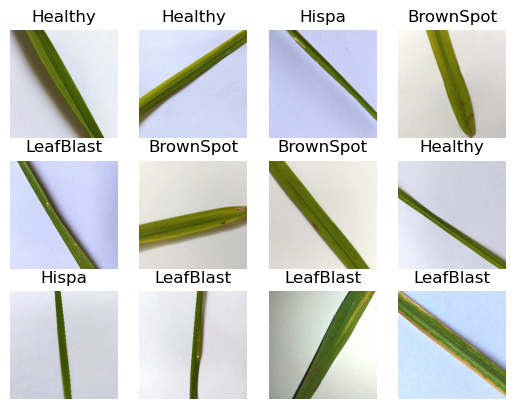

In [6]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
#print(image_batch[0].shape)
#print(label_batch.numpy())
#BrownSpot=0,Healthy=1,Hispa=2,LeafBlast=3

In [7]:
len(dataset)

84

In [8]:
#80% ==> training
#0% ==> validation
#10% ==> test

In [9]:
#training dataset
train_size=0.8
len(dataset)*train_size

67.2

In [10]:
train_ds=dataset.take(67)
len(train_ds)

67

In [11]:
#skipping the first 67
#testing dataset
test_ds=dataset.skip(67)
len(test_ds)

17

In [12]:
val_size=0.1
len(dataset)*val_size

8.4

In [13]:
#validation
val_ds=test_ds.take(8)
len(val_ds)


8

In [14]:
test_ds=test_ds.skip(8)
len(test_ds)

9

In [15]:
#splitting data set
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    
    
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

67

In [18]:
len(val_ds)

8

In [19]:
len(test_ds)

9

In [20]:
#GPU process
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#preprocessing pipeline API
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
# Define model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [25]:
# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


67/67 [==============================] - 88s 1s/step - loss: 1.3024 - accuracy: 0.4491 - val_loss: 1.2880 - val_accuracy: 0.4492
Epoch 2/50
67/67 [==============================] - 63s 942ms/step - loss: 1.2800 - accuracy: 0.4533 - val_loss: 1.2427 - val_accuracy: 0.4492
Epoch 3/50
67/67 [==============================] - 63s 947ms/step - loss: 1.1641 - accuracy: 0.5089 - val_loss: 1.0964 - val_accuracy: 0.5195
Epoch 4/50
67/67 [==============================] - 63s 947ms/step - loss: 1.0535 - accuracy: 0.5551 - val_loss: 1.0277 - val_accuracy: 0.6133
Epoch 5/50
67/67 [==============================] - 64s 948ms/step - loss: 1.0022 - accuracy: 0.5916 - val_loss: 0.9921 - val_accuracy: 0.6172
Epoch 6/50
67/67 [==============================] - 63s 945ms/step - loss: 0.9766 - accuracy: 0.6079 - val_loss: 1.0300 - val_accuracy: 0.6016
Epoch 7/50
67/67 [==============================] - 70s 1s/step - loss: 0.9862 - accuracy: 0.5963 - val_loss: 0.9890 - val_accuracy: 0.6250
Epo

In [27]:
scores=model.evaluate(test_ds)

9/9 [==============================] - 9s 217ms/step - loss: 0.6277 - accuracy: 0.7743


In [28]:
scores

[0.6277008056640625, 0.7743055820465088]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 67}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.4490654170513153,
 0.4532710313796997,
 0.5088785290718079,
 0.5551401972770691,
 0.5915887951850891,
 0.6079439520835876,
 0.5962616801261902,
 0.6042056083679199,
 0.6135513782501221,
 0.6233645081520081,
 0.6032710075378418,
 0.6060747504234314,
 0.6219626069068909,
 0.6018691658973694,
 0.6247663497924805,
 0.6238317489624023,
 0.6257009506225586,
 0.6308411359786987,
 0.6313084363937378,
 0.6261682510375977,
 0.6098130941390991,
 0.6285046935081482,
 0.6327102780342102,
 0.6196261644363403,
 0.6556074619293213,
 0.6668224334716797,
 0.69532710313797,
 0.6990654468536377,
 0.7023364305496216,
 0.7023364305496216,
 0.7191588878631592,
 0.7116822600364685,
 0.7392523288726807,
 0.7261682152748108,
 0.7308411002159119,
 0.7425233721733093,
 0.7439252138137817,
 0.7490653991699219,
 0.75,
 0.7607476711273193,
 0.7523364424705505,
 0.7570093274116516,
 0.764018714427948,
 0.7518691420555115,
 0.7612149715423584,
 0.764018714427948,
 0.76822429895401,
 0.7476635575294495,
 0.748598158

In [33]:
len(history.history['accuracy'])

50

In [34]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

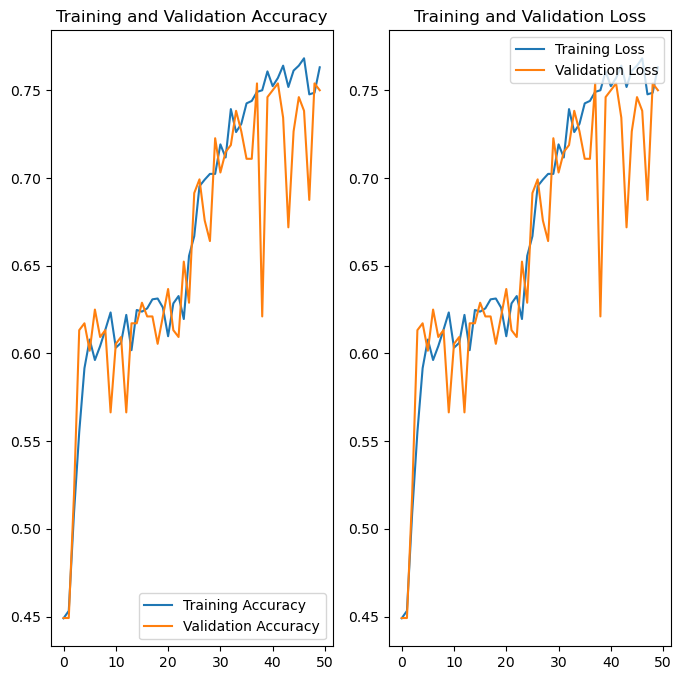

In [35]:
#plotting accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),acc,label='Training Loss')
plt.plot(range(EPOCHS),val_acc,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
#Run prediction on a sample image

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 467ms/step
predicted label: Healthy


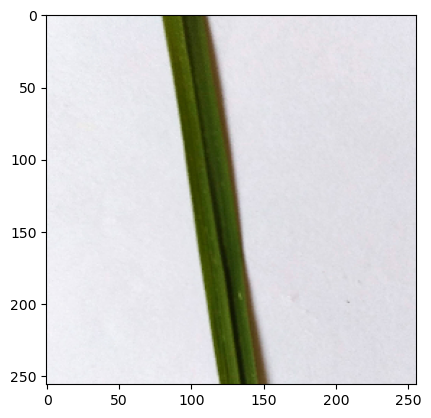

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
#Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [40]:
#Now run inference on few sample images

1/1 [==============================] - 0s 37ms/step


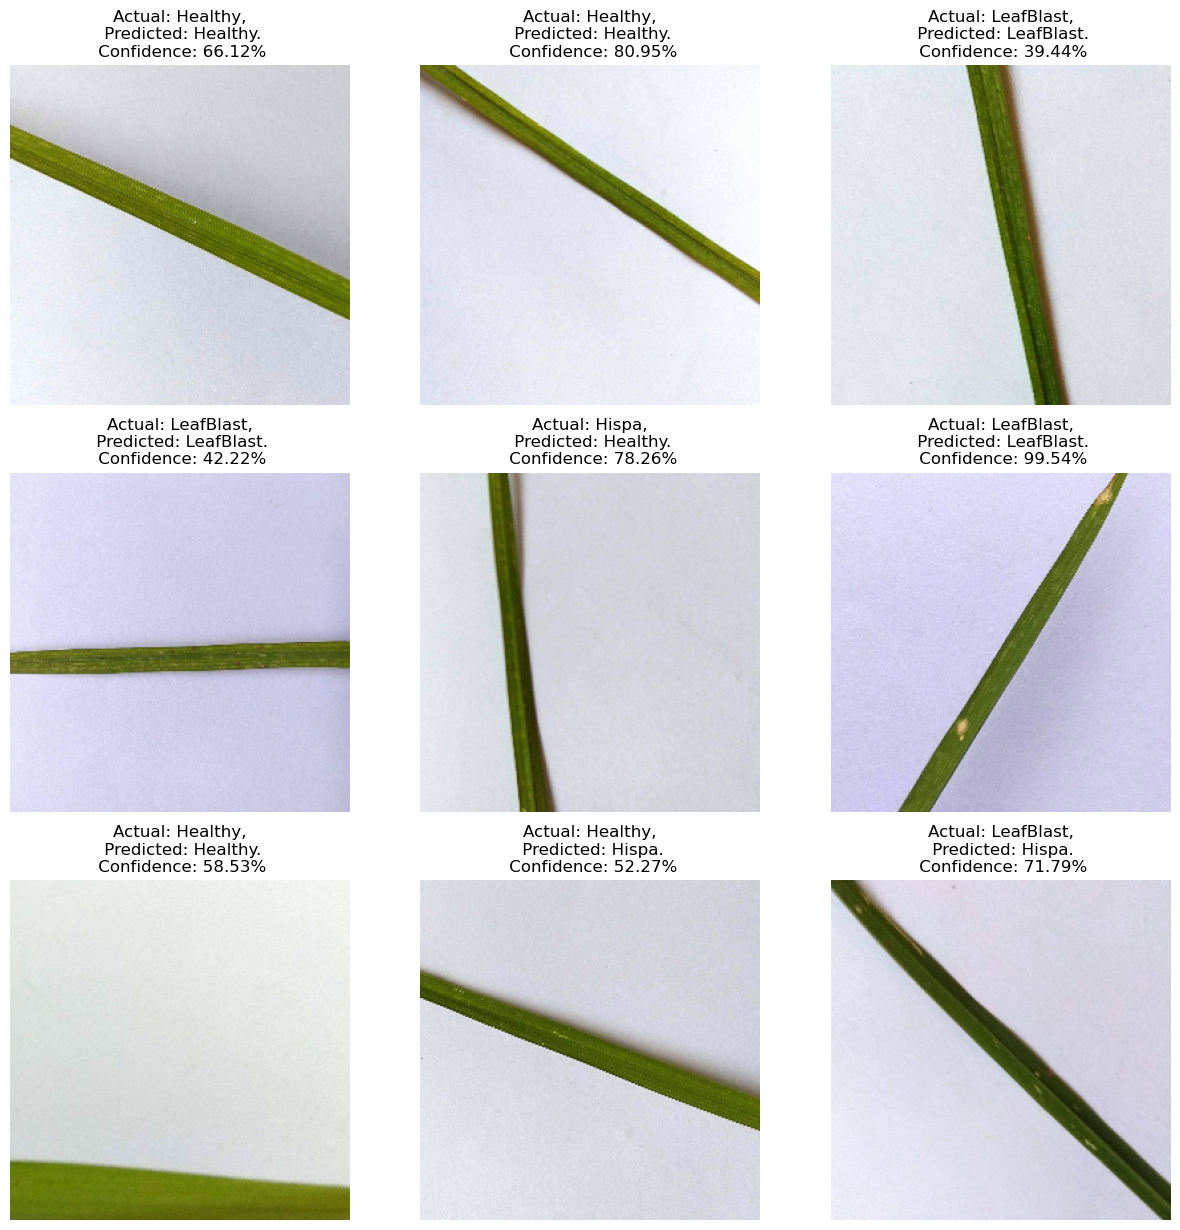

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [2]:
model_version=2
model.save(f"../models/{model_version}")

NameError: name 'model' is not defined

In [44]:
model.save("../Rice Leafs.h5")

C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

NameError: name 'model' is not defined